# PyTorch 101

Thamme Gowda  
tg (at) isi.edu  
October 21, 2020  

# Overview

1. Suggestions from the form
1. Installation
1. Common pitfalls
1. Show me your tools 
1. End-to-End Example 
1. Visualizations
  - tqdm
  - tensorbord

> I'd asked "what do you like to hear". And I recieved these responses:

## Suggestions/Pointers
1. I'm still relatively new to Python but enjoying it now.
1. I really want to learn about how to install PyTorch on Windows 
1. Common pitfalls that may lead to proper but slower training, how to efficiently use resources (cpu vs gpu etc)
1. Could you please share what your development environment looks like? Editors, software you use to monitor/manage job submission, tools you find useful. Basically, the good stuff that makes your life easier as a programmer :)
1. (x2) Real use cases and examples of applications in the real world (not just theory)
1. Track the training progress/visualization tips
1. Best practices above 'getting it to work’, 
1. I'd love to hear what steps one should take to get from "Beginner 2" --> "Intermediate", in the absence of a specific application (i.e. self-learning).
1. The gap between "beginner 2" and "intermediate" as described seems rather large.

# I'm still relatively new to Python but enjoying it now.
Welcome! 

Checkout our previous session on **Python Best Practices**

https://isi.edu/~tg/notes/Python-Best-Practices-TG-2019.pdf

# How to Install PyTorch ....
>I really want to learn about how to install PyTorch on Windows 

1. Use **conda** for environment managements and installations
  - use **miniconda**; its light 
  - To install miniconda: https://docs.conda.io/en/latest/miniconda.html 
  - `conda` works across platforms: Linux, OSX, Windows
  - `conda` can install system libs (e.g. cudatoolkit) without `sudo`
1. To install the latest PyTorch: https://pytorch.org/get-started/locally/ 
   - copy paste the command
   - To install prior versions: https://pytorch.org/get-started/previous-versions/ 
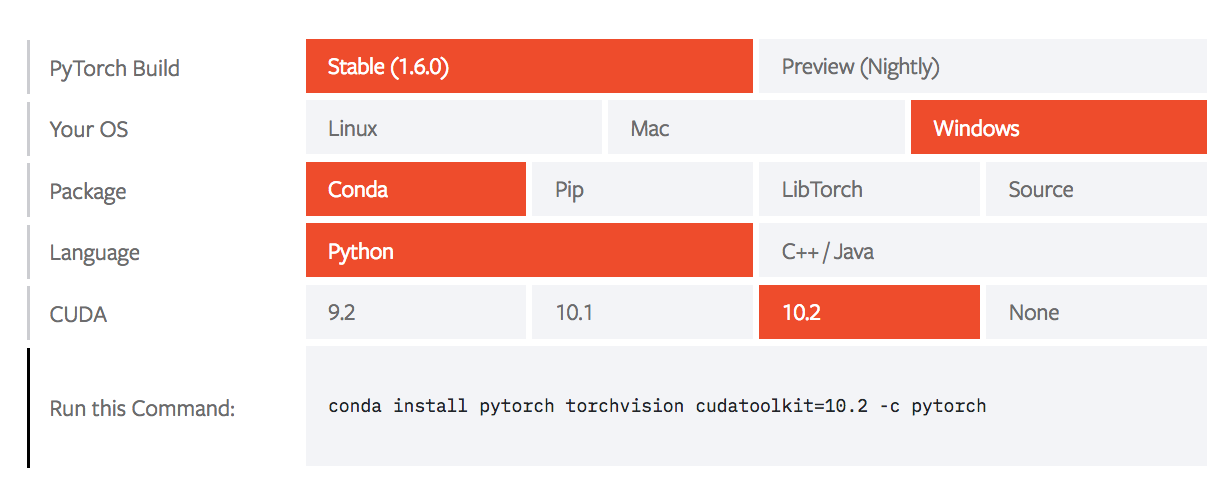

In [ ]:
# you may also install using pip (if cudatoolkit is not needed)
# however make sure that pip installs within a conda environment!

pip install torch torchvision torchtext 

# Show Me Your Tools

> Could you please share what your development environment looks like? 
> Editors, software you use to monitor/manage job submission, tools you find useful.
> Basically, the good stuff that makes your life easier as a programmer :)

- `git` and git branches
  - Github  issues to write down thoughts and ideas (on private repos)
- PyCharm IDE -- for development
  - great for debugging; we can inspect tensors, graphs etc
- `emacs` for editing quick fixes and runtime changes on server
  - you can also use `vim`
- `tmux` sessions 
- `htop` to view CPU + RAM utilization (shown later)
- `gpustat` to monitor GPU + GPU RAM utilization (shown later)
- `tqdm` to see training speed and ETA  (shown later)
- `tensorboard` for losses visualization (shown later)
- slurm batch scripts 

# Show Me Your Tools ...
- Good use of directory structure for projects and experiments
- Directory based history files. CTRL-R helps in quickly rerunning the experiments.
```bash
function mycd() {
    history -w       # write current history file
    builtin cd "$@"    # do actual cd
    export HISTFILE="$PWD/.history.$USER.txt" # set a new history file
    history -c # clear memory
    history -r # read from current histfile
}
shopt -s histappend
alias cdd=$(which cd)
alias cd="mycd"
```

# Common Pitfalls

> Common pitfalls that may lead to proper but slower training, how to efficiently use resources (cpu vs gpu etc)

1. Main question: Why the GPU utilization is NOT reaching ~90-100%?
1. Simple answer: Is it possible to fit bigger batches?
1. If GPU is free but CPU is busy
  - Use batch operations that runs on GPU instead of CPU loops
  - Is maybe possible to achieve the outcome of `for` loop with `torch.*` API.
  - Maybe more CPU cores are needed for your data loading
  - Using slurm ? know about CPU affinity `-n 10` vs `-n 1 -c 10`
1. If both GPU and CPU are free
  - Q: Is the disk too slow?
  - Usually networked storages on HPC are slow. 
  - Option1: copy your training data to a faster local storage
  - Option2: is it possible to keep training data in CPU RAM?

# Common Pitfalls ... 
- OOM: Memory Leak. Memory not freed. Garbage is not collected.
  - Garbage collector wont free memory if there are any refences to it
  - e.g. `lst.add(obj)` or `tmp = obj` keeps hold of `obj` 
  - Always loose references to batch objects once you are done with them
  - `tensor.detach()` to remove ref to graphs
  - Use lazy, generators (such as `yield`) instead of eager, buffered ops
    - `lazy = (x for x in range(n))`
    - `eager = [x for x in range(n)]`
- Python has limitations, we need to workaround them
 - Python is not really good in `multithreading` because it has global interpreter lock (GIL)
 - So we use `multiprocessing`, but that requires pickle dump -> load. These can be too costly.
 - If you are creating a lot of objects of a certain class (e.g. `Example`). Use `__slots__`
 - Did you know: An integer in python is 28 bytes and a float is 24 bytes!
 - [Python's built-in list keeps a pointer to each item => each item in `List[int]` is 28 + 8 = 36 bytes](https://webcourses.ucf.edu/courses/1249560/pages/python-lists-vs-numpy-arrays-what-is-the-difference)
     - This is why we should use `numpy` or `torch` early in the data preparation stage!  

# Intro to Pytorch API 
- Pytorch's API is similar to NumPy's API
- Pytorch = NumPy + GPU_Acceleration + AutoGrad + LossFunctions + Optimizers + Common NN Modules …
- Familiarity of Numpy is a huge advantage
  - NumPy Cheat sheet https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Numpy_Python_Cheat_Sheet.pdf
- Is PyTorch Functional or Object-oriented?
  - We, python programmers, normally use both. Pytorch offers both choices.
  - Functional: 
    - `import torch.nn.functional as F`
    - `F.cross_entropy(...)`
    - `torch.max(tensor)`
  - Object-oriented:
    - `import torch.nn as nn`
    - `nn.CrossEntropy(...)`
    - `tensor.max()`
  - Pytorch docs cross-reference each other
- Pytorch builds dynamic graph under the hood
 - for gradient backpropagation
- Inplace operations ends with `*_` e.g. `.scatter_(...)` vs `.scatter(...)`
  - Always use out-of-place ops i.e. without trailing `*_`
  - Use inplace ops (with `*_`) when you know what you are doing. 

# CPU or GPU ?
- Its best to make your code run on both CPU and GPU
- Prefer to run on GPU, but automatically fall back to CPU 
  - So we can debug on laptop with IDE like PyCharm
- Add `--gpu-only` CLI flag for production use, and fail early if GPU is not available
  - Especially useful when on shared cluster with unreliable hardwares
- DONOT hardcode a specific GPU such as `cuda:2`
  - Instead use environment variable `export CUDA_VISIBLE_DEVICES=2`

In [34]:
import logging as log
from pathlib import Path
import torch

log.basicConfig(level=log.INFO)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
log.info(f'device={device}')

INFO:root:device=cuda


# End to End Example

> Real use cases and examples of applications in the real world (not just theory)

- Keep a tab open for pytorch docs : https://pytorch.org/docs/stable/index.html
  - We will need it. In fact we may have to keep multiple tabs open!
- Task: Text Classification
- Dataset: Using `torchtext` to retrieve a dataset
- Model: Transformer Encoder  (might not go in depth)
- Tracking and visualizatiom of training
  - `tqdm`
  - `tensorboard`

## Prepare a Dataset

- using torchtext
- For `torchtext` docs refer to https://pytorch.org/text/experimental_datasets.html

In [4]:
from torchtext.experimental.datasets import YahooAnswers, DBpedia, AG_NEWS

root = 'cache-torchtext'
#train, test = YahooAnswers(root=root)
#train, valid = DBpedia(root=root)
train, valid = AG_NEWS(root=root)   # using this because it is small
type(train), type(valid)

INFO:root:Downloading from Google Drive; may take a few minutes
INFO:root:File cache-torchtext/ag_news_csv.tar.gz already exists.
INFO:root:Opening tar file cache-torchtext/ag_news_csv.tar.gz.
INFO:root:cache-torchtext/ag_news_csv/train.csv already extracted.
INFO:root:cache-torchtext/ag_news_csv/test.csv already extracted.
INFO:root:cache-torchtext/ag_news_csv/classes.txt already extracted.
INFO:root:cache-torchtext/ag_news_csv/readme.txt already extracted.
120000lines [00:01, 111867.30lines/s]


(torchtext.experimental.datasets.text_classification.TextClassificationDataset,
 torchtext.experimental.datasets.text_classification.TextClassificationDataset)

# DataLoader with Mini Batches

- Torch's [datatypes](https://pytorch.org/docs/stable/tensors.html#torch-tensor)
- [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)


In [21]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    texts, labels = [], []
    for label, txt in batch:
        texts.append(txt)
        labels.append(label)        
    return texts, labels

train_loader = DataLoader(train, batch_size=3, collate_fn=collate_fn, shuffle=True)

for idx, (texts, labels) in enumerate(train_loader):
    print(idx, labels)
    print(texts)
    break

0 [tensor(3), tensor(3), tensor(3)]
[tensor([ 4671,  1155,  2008, 27611,    83,    30,   711,   618,    53,    72,
           12,    42,   165,     2,     2,     2,    42,   164, 32904,     4,
         9087,     2,    14,  1013,    15,    16,    47,    73,   751,  4671,
         5448,     9,  2008,    34,   412,     8, 27611,    83,     8,   682,
           30,     3,  6749,  3302,   618,    53,    72,     4,  1457, 23775,
        20166,  1076,    66,     2]), tensor([   52,     2,    10,     2,   864,   942,   356,  1486,  1701,  4501,
           24,    74,    14,    28,    15,    16,    52,     2,    10,     2,
          864,   942,    80,   449,    11,    58,     4,    20,     6,   669,
            8,   286,    55,  1701,   677,    65,     2,    42,     6,   260,
          256,     2,   254,     2,    28,     2,   310,     2,   309,    81,
        27181,     2,   138,   311, 16318,     2,   502,   258,  6184,     6,
         3002,  1847,    11,  8733,    65,     2,    42,     6,   2

We have unequal length sequences:
- use padding
- keep track of lengths

In [5]:
# vocabul
train.vocab.itos[:10]
PAD_IDX = train.vocab.stoi['<pad>']
UNK_IDX = train.vocab.stoi['<unk>']
log.info(f'vocabulary size= {len(train.vocab):,}')
log.info(f'<unk>={UNK_IDX}')
log.info(f'<pad>={PAD_IDX}')

from collections import Counter
all_labels = Counter(label for label, txt in train.data)
print(all_labels)

INFO:root:vocabulary size= 95,812
INFO:root:<unk>=0
INFO:root:<pad>=1


Counter({3: 30000, 4: 30000, 2: 30000, 1: 30000})


In [6]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    texts, labels = [], []
    for label, txt in batch:
        texts.append(txt)
        labels.append(label)

    labels = torch.tensor(labels, dtype=torch.uint8)    
    lengths = [len(txt) for txt in texts]
    lengths = torch.tensor(lengths, dtype=torch.short)

    seqs = torch.full(size=(len(texts), lengths.max()),
                      fill_value=PAD_IDX, dtype=torch.long)
    for idx, txt in enumerate(texts):
        seqs[idx, :len(txt)] = txt
    
    return seqs, labels, lengths
train_loader = DataLoader(train, batch_size=3, collate_fn=collate_fn, shuffle=True)

for idx, (texts, labels, lengths) in enumerate(train_loader):
    print(idx, labels, lengths)
    print(texts)
    break

0 tensor([2, 1, 3], dtype=torch.uint8) tensor([27, 35, 35], dtype=torch.int16)
tensor([[    6,    17,    10,   916,  9506,  9426,  3603,  5293,  1720,  9506,
            29, 13413,     6, 29183,    18,    94,  1319,   284,    30,     3,
          1601,  2817,     5,     3,  1387,  2382,     2,     1,     1,     1,
             1,     1,     1,     1,     1],
        [ 1634,   673,    12,    24,  2039,     5,  1218,  1220,     3,  1558,
           214,     4,   334,  2606,  1634,     4,    29,   441,    12,     6,
            24,  2039,     5,  5633,     3, 21941,  1220,    19,   197,    39,
             3,  2410,     7,  1218,     2],
        [   37,   254,  1800,    67,  6355, 20892,     6,    37,   930,  2979,
            99,  1376,    27,    26,    87,  2074,     6,  2051,   746,     8,
          3561,  8028,  5720,  6355, 20892,     8,     6,   122, 14697,     3,
            55,    21,  9588,    83,     2]])


In [25]:
from torch.utils.data import DataLoader
from dataclasses import dataclass

@dataclass
class Batch:

    texts: torch.Tensor
    labels: torch.Tensor
    lengths: torch.Tensor

    def __len__(self):
        return len(seqs) 

    def tok_count(self):
        return self.lengths.sum()

    def to(self, device):
        # there is an option called pin_memory for advanced users
        self.texts = self.texts.to(device)
        self.labels = self.labels.to(device)
        self.lengths = self.lengths.to(device)        
        return self

    @classmethod
    def collate_fn(cls, batch, max_len=80) -> 'Batch':
        # handle edge cases, define max_len 
        texts, labels = [], []
        for label, txt in batch:
            texts.append(txt[:max_len])
            labels.append(label)

        labels = torch.tensor(labels, dtype=torch.uint8)    
        lengths = [len(txt) for txt in texts]
        lengths = torch.tensor(lengths, dtype=torch.short)

        seqs = torch.full(size=(len(texts), lengths.max()),
                          fill_value=PAD_IDX, dtype=torch.long)
        for idx, txt in enumerate(texts):
            seqs[idx, :len(txt)] = txt
    
        return cls(texts=seqs, labels=labels, lengths=lengths)

train_loader = DataLoader(train, batch_size=3, collate_fn=Batch.collate_fn, shuffle=True)

for idx, batch in enumerate(train_loader):
    print(idx, batch.labels, batch.lengths)
    print(batch.texts)
    break

0 tensor([3, 2, 2], dtype=torch.uint8) tensor([43, 40, 39], dtype=torch.int16)
tensor([[  362,    13,   373,    13,     5,   449,    59,    93,    59,    93,
            34,   288,   428,   157,   317,  6395,    43,  5680,     4,     3,
          1302,     7,    59, 83328,    13,  3889,  1382,    29,   683,     2,
          1382,    77, 12959, 13418,    27,    23,   787,    80,  2444,   720,
             5,   661,   238],
        [ 4754,   555,  1007,    14,   753,    15,  9327,  2174,    11,   528,
          2099, 18472,     2,  1066,    14,  1516,    15,  8538,    48,  1492,
           228, 78419,  7327,     4,  4443,   228,  2436, 93570,     4,  5380,
           228, 12964, 14440,     4,     9,  5567, 26241, 19083, 62017,     2,
             1,     1,     1],
        [ 5291,  1674,   270,    19,   404,     6, 87844,   621,     4, 32433,
            25,   854,  5291,     7,   359,    13,    10,  1023,   175,   112,
             4,  1204,     5, 39621,   476,    20,   807,    30,   99

# `tqdm` progress bar

- tqdm can be used to create a very useful progress bar 
- `pip install tqdm`
- Docs https://github.com/tqdm/tqdm#documentation 

In [26]:
from tqdm import tqdm
from time import time as time_now

steps = 100000

count = 0
epoch = 0
total_toks = 0
start_time = time_now()
while count < steps:
    # https://github.com/tqdm/tqdm#documentation 
    with tqdm(train_loader) as pbar:
        for batch in pbar:
            count += 1
            total_toks += batch.tok_count()
            toks_speed = int(total_toks / (time_now() - start_time))
            pbar.set_postfix(dict(updates=count, epoch=epoch, toks_speed=f'{toks_speed:,}'))
            if count % 100 == 0:  # stoping early for quick demo
                break
    log.info(f'Epoch {epoch} completed')
    epoch += 1
    if epoch > 2:
        break

  0%|          | 99/40000 [00:00<01:16, 518.64it/s, updates=100, epoch=0, toks_speed=68,762]
INFO:root:Epoch 0 completed
  0%|          | 99/40000 [00:00<01:04, 620.59it/s, updates=200, epoch=1, toks_speed=74,080]
INFO:root:Epoch 1 completed
  0%|          | 99/40000 [00:00<01:01, 646.97it/s, updates=300, epoch=2, toks_speed=77,203]
INFO:root:Epoch 2 completed


# Flatten Epochs to Make a Better Progressbar

- tqdm shows the __time remaining__, which is a useful info in practice

In [2]:
from tqdm import tqdm
from time import time as time_now

def looping_iter(data, total):
    """Flattens multiple epoch loops into one """
    count = 0
    epoch = 0
    last_time = time_now()
    while count < total:
        for item in data:
            yield item
            count += 1
            if count >= total:
                break
        if count < total and (time_now() - last_time) > 5:
            # dont log too frequently than 5 secs; happens on short datasets
            log.info(f"End of epoch {epoch}")
            last_time = time_now()
        epoch += 1

steps = 100_000
total_toks = 0
start_time = time_now()
data = looping_iter(train_loader, total=steps)
with tqdm(data, total=steps) as pbar:
    for count, batch in enumerate(pbar):
        total_toks += batch.tok_count()
        toks_speed = int(total_toks / (time_now() - start_time))
        pbar.set_postfix_str(f'speed={toks_speed:,}toks/sec')
        if (count + 1) % 1000 == 0:  # testing 
            break

NameError: name 'train_loader' is not defined

# Trainer

- Model
- Optimizer
- Loss Function or objectve function
- Training data, validation data

In [9]:
import torch.nn as nn                     # neural networks
import torch.nn.functional as F           # layers, activations and more
import torch.optim as optim

@dataclass
class Trainer:
    model: nn.Module
    opt: optim.Optimizer
    #loss_func = nn.CrossEntropyLoss()      # object oriented API
    loss_func = F.cross_entropy             # functional API 

# I use object-oriented API for components with states
#    and functional API for stateless components

In [10]:
from tqdm import tqdm
from time import time as time_now

  
@dataclass
class Trainer:
    model: nn.Module
    opt: optim.Optimizer = None
    loss_func = F.cross_entropy
    device = device

    def train(self, train_loader: DataLoader, valid_loader: DataLoader, steps: int, checkpoint: int):
        total_toks = 0
        start_time = time_now()
        train_data = looping_iter(train_loader, total=steps)
        with tqdm(train_data, total=steps) as databar:
            for step, batch in enumerate(databar, start=1):
                total_toks += batch.tok_count()
                toks_speed = int(total_toks / (time_now() - start_time))

                databar.set_postfix_str(f'{toks_speed:,}toks/sec')
                # TODO: train 

                if step % checkpoint == 0:
                    log.info(f"TODO: checkpoint at step: {step:,}")

BATCH_SIZE = 40
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, collate_fn=Batch.collate_fn)
valid_loader = DataLoader(valid, batch_size=BATCH_SIZE, shuffle=False, collate_fn=Batch.collate_fn)

trainer = Trainer(model=None, opt=None)
trainer.train(train_loader, valid_loader, steps=1000, checkpoint=200)

100%|█████████▉| 999/1000 [00:04<00:00, 220.32it/s, 378,886toks/sec]


In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model

- Lets view model as a black box (for now)
- We will see inside of it if we have time
- Visualization tip: `str(model)` gives a basic visualization of model

In [37]:
from model import TextClassifier

vocab = train.vocab
n_classes = max(all_labels) + 1
model_args = dict(vocab_size=len(vocab), n_classes=n_classes,
                  model_dim=128, n_heads=2, n_layers=2, ff_dim=256,
                  padding_idx=PAD_IDX)

# Note: save model_args somewhere
model = TextClassifier(**model_args)

In [37]:
log.info(f'Model:\n{model}')

INFO:root:Model:
TextClassifier(
  (embeddings): Sequential(
    (0): Embedding(95812, 128, padding_idx=1)
    (1): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=128, ou

# Putting It All Together

In [38]:
from tqdm import tqdm
from time import time as time_now

class Trainer:

    def __init__(self, model, lr=5e-4, device=device,
                 opt=None, loss_func=None, lr_scheduler=None):
        self.device = device        
        self.model = model.to(self.device)
        self.opt = opt or optim.Adam(self.model.parameters(), lr=lr)
        self.loss_func = loss_func or F.cross_entropy
        self.lr_scheduler = lr_scheduler
        
    def validate(self, valid_loader) -> float:
        total = 0.
        count = 0
        for batch in valid_loader:
            batch.to(device)
            scores = self.model(texts=batch.texts, lengths=batch.lengths, out='raw')
            loss = self.loss_func(input=scores, target=batch.labels.long(), reduction='mean')
            total += loss.item()
            count += 1
        return total / count

    def train(self, train_loader: DataLoader, valid_loader: DataLoader, steps: int, checkpoint: int):
        train_loss = 0.
        total_toks = 0
        start_time = time_now()
        self.model.train(True) #Training mode
        train_data = looping_iter(train_loader, total=steps)
        with tqdm(train_data, total=steps) as databar:
            for step, batch in enumerate(databar, start=1):
                batch.to(self.device)

                scores = self.model(texts=batch.texts, lengths=batch.lengths, out='raw')
                # NOTE: loss_func accepts long values for target 
                loss = self.loss_func(input=scores, target=batch.labels.long(), reduction='mean')

                loss.backward()
                self.opt.step()
                self.opt.zero_grad()

                loss_val = loss.detach().item()
                train_loss += loss_val
                total_toks += batch.tok_count()
                toks_speed = int(total_toks / (time_now() - start_time))

                databar.set_postfix_str(f'loss:{loss_val:.4f} speed:{toks_speed:,}toks/sec', refresh=False)

                if step % checkpoint == 0:
                    with torch.no_grad():
                        self.model.train(False)
                        val_loss = self.validate(valid_loader)
                        train_loss /= checkpoint
                        log.info(f'\nCheckpoint at {step}; train_loss={train_loss:.4f} valid_loss={val_loss:.4f}')
                        # TODO: checkpoint
                        self.model.train(True)
                        train_loss = 0.
                        start_time = time_now()
                        total_toks = 0


In [32]:
BATCH_SIZE = 600
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, collate_fn=Batch.collate_fn)
valid_loader = DataLoader(valid, batch_size=BATCH_SIZE, shuffle=False, collate_fn=Batch.collate_fn)

# TIP: Check if the model can overfit to smaller dataset
- If we can overfit our model to a smaller dataset, then it is a good model
  - most importantly, it also means no obvious bugs
-  _smaller dataset_ e.g. 1 batch
- This is a very useful sanity checker
- overfitting = training loss becomes zero

In [42]:
trainer = Trainer(model=model)
batch1 = next(iter(train_loader))
try:
    trainer.train(train_loader=[batch1], valid_loader=valid_loader, steps=2000, checkpoint=100)
except KeyboardInterrupt:
    pass

  5%|▍         | 96/2000 [00:01<00:19, 97.44it/s, loss:0.0039 speed:80,945toks/sec]INFO:root:
Checkpoint at 100; train_loss=0.1950 valid_loss=3.3558
 10%|▉         | 192/2000 [00:03<00:22, 81.52it/s, loss:0.0019 speed:88,482toks/sec]INFO:root:
Checkpoint at 200; train_loss=0.0026 valid_loss=3.5288
 15%|█▍        | 298/2000 [00:05<00:19, 87.45it/s, loss:0.0009 speed:88,510toks/sec]INFO:root:
Checkpoint at 300; train_loss=0.0018 valid_loss=3.6114
 20%|█▉        | 396/2000 [00:08<00:19, 82.86it/s, loss:0.0007 speed:89,621toks/sec]INFO:root:
Checkpoint at 400; train_loss=0.0009 valid_loss=3.7241
 22%|██▏       | 449/2000 [00:10<00:35, 43.93it/s, loss:0.0008 speed:88,565toks/sec]


# Monitor GPU Usage

In [23]:
!gpustat

saga22                  Tue Oct 20 20:37:15 2020  440.44
[0] GeForce GTX 1080 Ti | 30'C,   0 % |  1293 / 11178 MB | tg(1283M)


# Speed on CPU vs GPU

- A test that the code can easily switch between CPU and GPU
- And later it can switch between multiple GPUs


In [ ]:
# Check speed on CPU 
trainer2 = Trainer(model=model, device='cpu')
trainer2.train(train_loader=train_loader, valid_loader=valid_loader, steps=10000, checkpoint=1000)

In [ ]:
# Check speed on GPU
trainer = Trainer(model=model, device='cuda')
trainer.train(train_loader=train_loader, valid_loader=valid_loader, steps=10000, checkpoint=1000)

In [ ]:
BATCH_SIZE = 600  # TODO increase batch size
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, collate_fn=Batch.collate_fn)
valid_loader = DataLoader(valid, batch_size=BATCH_SIZE, shuffle=False, collate_fn=Batch.collate_fn)
trainer = Trainer(model=model, device='cuda')
trainer.train(train_loader=train_loader, valid_loader=valid_loader, steps=10000, checkpoint=1000)

---
# Tracking the Training Progress/Visualization tips


- `tqdm` already shows some basic info
- For more advanced, we use **Tensorboard**
- Tensorboard is part of `torch.utils.tensorboard` package
```python
from torch.utils.tensorboard import SummaryWriter
```
- The class takes these args
```python
SummaryWriter(log_dir=None, comment='', purge_step=None, max_queue=10, flush_secs=120, filename_suffix='')
```
- SummaryWriter offers these functions:
```python
add_scalar(tag, scalar_value, global_step=None, walltime=None)
add_scalars(main_tag, tag_scalar_dict, global_step=None, walltime=None)
add_graph(model, input_to_model=None, verbose=False)
add_embedding(mat, metadata=None, label_img=None, global_step=None, tag='default', metadata_header=None)
add_text(tag, text_string, global_step=None, walltime=None)
add_histogram(tag, values, global_step=None, bins='tensorflow', walltime=None, max_bins=None)
add_image(tag, img_tensor, global_step=None, walltime=None, dataformats='CHW')
add_images(tag, img_tensor, global_step=None, walltime=None, dataformats='NCHW')
add_figure(tag, figure, global_step=None, close=True, walltime=None)
add_video(tag, vid_tensor, global_step=None, fps=4, walltime=None)
add_audio(tag, snd_tensor, global_step=None, sample_rate=44100, walltime=None)
add_pr_curve(tag, labels, predictions, global_step=None, num_thresholds=127, weights=None, walltime=None)
add_hparams(hparam_dict=None, metric_dict=None)
```
- Install tensorboard: `pip install tensorboard`
- To launch tensorboard server
```bash
tensorboard --logdir <dirname> # --host 0.0.0.0
```

In [32]:
from torch.utils.tensorboard import SummaryWriter

class Trainer:

    def __init__(self, model, lr=5e-4, device=device,
                 opt=None, loss_func=None, lr_scheduler=None):
        self.device = device        
        self.model = model.to(self.device)
        self.opt = opt or optim.Adam(self.model.parameters(), lr=lr)
        self.loss_func = loss_func or F.cross_entropy
        self.lr_scheduler = lr_scheduler
        self.tbd = SummaryWriter(log_dir='tensorboard-logs')    # 👈 
        
    def validate(self, valid_loader) -> float:
        total = 0.
        count = 0
        for batch in valid_loader:
            batch.to(device)
            scores = self.model(texts=batch.texts, lengths=batch.lengths, out='raw')
            loss = self.loss_func(input=scores, target=batch.labels.long(), reduction='mean')
            total += loss.item()
            count += 1
        return total / count
    
    def log_model_graph(self, batch):
        # input is needed to extract the dynamic graph 
        self.tbd.add_graph(self.model, (batch.texts, batch.lengths))  #👈


    def train(self, train_loader: DataLoader, valid_loader: DataLoader, steps: int, checkpoint: int):        
        inp_emb_names = train_loader.dataset.vocab.itos
        train_loss = 0.
        total_toks = 0
        start_time = time_now()
        self.model.train(True) #Training mode
        train_data = looping_iter(train_loader, total=steps)
        with tqdm(train_data, total=steps) as databar:
            for step, batch in enumerate(databar, start=1):
                batch.to(self.device)
                if step == 1:                            # 👈
                    self.log_model_graph(batch) 

                scores = self.model(texts=batch.texts, lengths=batch.lengths, out='raw')
                # NOTE: loss_func accepts long values for target 
                loss = self.loss_func(input=scores, target=batch.labels.long(), reduction='mean')

                loss.backward()
                self.opt.step()
                self.opt.zero_grad()

                loss_val = loss.detach().item()
                train_loss += loss_val 
                self.tbd.add_scalar('train_loss', loss_val, step)    # 👈

                train_loss += loss_val
                total_toks += batch.tok_count()
                toks_speed = int(total_toks / (time_now() - start_time))
                databar.set_postfix_str(f'loss:{loss_val:.4f} speed:{toks_speed:,}toks/sec', refresh=False)

                if step % checkpoint == 0:
                    with torch.no_grad():
                        self.model.train(False)
                        val_loss = self.validate(valid_loader)
                        train_loss /= checkpoint
                        #👇
                        self.tbd.add_scalars('chkpt_losses', {'train': train_loss, 'valid': val_loss}, step)  
                        self.tbd.add_embedding(mat=self.model.embeddings[0].weight[:500,:], global_step=step,
                                               metadata=inp_emb_names[:500], tag='input_embedding')
                        self.tbd.add_embedding(mat=self.model.cls_proj.weight, global_step=step,
                                               tag='output_embedding')

                        log.info(f'\nCheckpoint at {step}; train_loss={train_loss:.4f} valid_loss={val_loss:.4f}')
                        # TODO: checkpoint
                        self.model.train(True)
                        train_loss = 0

In [33]:
BATCH_SIZE = 20
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, collate_fn=Batch.collate_fn)
valid_loader = DataLoader(valid, batch_size=BATCH_SIZE, shuffle=False, collate_fn=Batch.collate_fn)

trainer = Trainer(model=model)
trainer.train(train_loader=train_loader, valid_loader=valid_loader, steps=10000, checkpoint=1000)

 10%|▉         | 992/10000 [00:12<01:52, 79.97it/s, loss:0.1420 speed:70,991toks/sec]INFO:root:
Checkpoint at 1000; train_loss=0.5742 valid_loss=0.3067
 20%|█▉        | 1992/10000 [00:25<01:29, 89.15it/s, loss:0.0703 speed:66,030toks/sec]INFO:root:
Checkpoint at 2000; train_loss=0.5811 valid_loss=0.3123
 30%|██▉       | 2995/10000 [00:40<01:22, 85.26it/s, loss:0.2699 speed:64,007toks/sec]INFO:root:
Checkpoint at 3000; train_loss=0.5717 valid_loss=0.3092
 40%|███▉      | 3994/10000 [00:53<01:09, 86.61it/s, loss:0.2113 speed:63,801toks/sec]INFO:root:
Checkpoint at 4000; train_loss=0.5595 valid_loss=0.2894
 50%|████▉     | 4994/10000 [01:07<00:55, 89.96it/s, loss:0.2155 speed:63,352toks/sec]INFO:root:
Checkpoint at 5000; train_loss=0.5757 valid_loss=0.2833
 60%|█████▉    | 5998/10000 [01:20<00:45, 87.62it/s, loss:0.1639 speed:63,808toks/sec]INFO:root:
Checkpoint at 6000; train_loss=0.5650 valid_loss=0.2813
INFO:root:End of epoch 0
 70%|██████▉   | 6994/10000 [01:35<00:36, 82.15it/s, loss:

# Best Practices Above 'Getting it to Work’

- Design Experiments such that
  - Can be interrupted, restored and resumed
    - Some shared clusters have 24hrs wall time limit
  - Reproducible, even after 3+ years
  - Easily shared with others
- Create a central `config` file per experiment
  - one central place for all configs
- Setup experiment directory such that it can be zipped and shared with others for collaboration
- Zip your source code and place it inside the experiment
  - Because research code quickly evolves and breaks older experiments
  - `PYTHONPATH=<experiment>/yourcode.zip python -m module.submodule` to run 
  - git HEAD for cross referencing: `git rev-parse HEAD > $OUT/githead`
- Example Experiment https://github.com/thammegowda/005-nmt-imbalance/tree/master/runs-ende-001m/066-ende-16k16k-r1
- Example slurm pipeline https://github.com/isi-nlp/rtg-xt/blob/master/scripts/rtg-pipeline.sh

# Example NMT Experiment
```
001-experiment/         <-- Assign a number for experiment
├── conf.yml            <-- one central config file
├── data                <-- training, validation data and vocabularies
│   ├── nlcodec.src.model
│   ├── nlcodec.tgt.model
│   ├── samples.tsv.gz    <-- log these random samples from validation set
│   ├── train.db
│   ├── valid.tsv.gz
├── githead           <-- git HEAD 
├── job.sh.bak        <-- backup of slurm batch script that was submitted 
├── logs              
│   └── rtg.log-26366  <-- log with PID
├── models             <-- checkpoints
│   ├── model_10000_1.061773_1.887741.pkl
│   ├ ... 
│   ├── model_9000_1.083095_1.853299.pkl
│   └── scores.tsv    <-- train, validan losses. quicker access than tensorboard
├── rtg.zip           <-- source code zip; to run: PYTHONPATH=rtg.zip python -m rtg.pipe 
├── tensorboard
├── test_step17000_beam4_ens10_lp0.6      <-- tests after the training 
│   ├── dev.out.mosesdetok.lc.sacrebleu
│   ├── dev.out.tsv
│   ├── dev.ref
│   ├── dev.src
│   ├── test.out.mosesdetok.lc.sacrebleu
│   ├── test.out.tsv
│   ├── test.ref
│   └── test.src
├── _PREPARED        <-- Flag saying data prep is done, so it wont do twice
└── _TRAINED         <-- Flag saying experiment finished training
```

# Beginner 2 --> Intermediate

> I'd love to hear what steps one should take to get from "Beginner 2" --> "Intermediate", in the absence of a specific application (i.e. self-learning).

- Please implement a model end-to-end 
- Chose a popular model in your domain
  - For NLP, write code for transformers
- Understand every line in code

# Thanks 🙏🏼

- This notebook is available at https://github.com/thammegowda/202010-pytorch/
